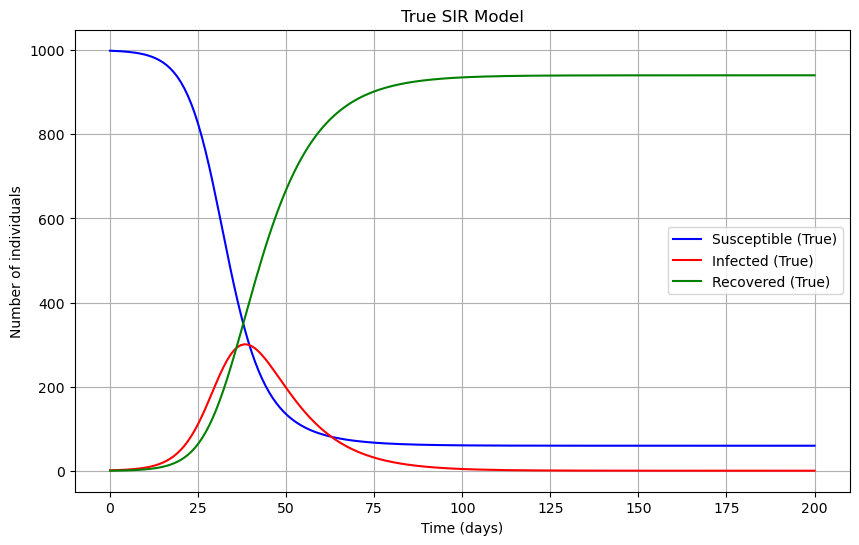

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint

# Parameters
beta_true = 0.3  # true infection rate
gamma_true = 0.1  # true recovery rate
N = 1000    # total population
I0 = 1      # initial number of infected individuals
R0 = 0      # initial number of recovered individuals
S0 = N - I0 - R0  # initial number of susceptible individuals

# True SIR model differential equations
def true_sir(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Time vector
t = np.linspace(0, 200, 200)  # 200 days

# Generate true epidemic data
y_true = odeint(true_sir, [S0, I0, R0], t, args=(beta_true, gamma_true))
S_true, I_true, R_true = y_true.T

# Plot the true epidemic data
plt.figure(figsize=(10, 6))
plt.plot(t, S_true, 'b', label='Susceptible (True)')
plt.plot(t, I_true, 'r', label='Infected (True)')
plt.plot(t, R_true, 'g', label='Recovered (True)')
plt.title('True SIR Model')
plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Convert data to PyTorch tensors
t_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1)
I_tensor = torch.tensor(I_true, dtype=torch.float32).view(-1, 1)

# Define DataLoader if batching is needed (not necessary for this example)
# from torch.utils.data import DataLoader, TensorDataset
# dataset = TensorDataset(t_tensor, I_tensor)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [17]:
# Define the neural network model using nn.Module
class SIRModel(nn.Module):
    def __init__(self):
        super(SIRModel, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)  # Output layer: 2 neurons for beta and gamma
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, optimizer, and loss function
model = SIRModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(t_tensor)
    
    # Calculate loss
    loss = criterion(outputs, I_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 8909.0654
Epoch [200/1000], Loss: 8893.6113
Epoch [300/1000], Loss: 8877.5967
Epoch [400/1000], Loss: 8777.4131
Epoch [500/1000], Loss: 8675.4180
Epoch [600/1000], Loss: 8495.4033
Epoch [700/1000], Loss: 8194.3594
Epoch [800/1000], Loss: 7727.3594
Epoch [900/1000], Loss: 7058.7856
Epoch [1000/1000], Loss: 6195.0449


Predicted beta: 7.533
Predicted gamma: 4.209


AttributeError: Line2D.set() got an unexpected keyword argument 'lab'

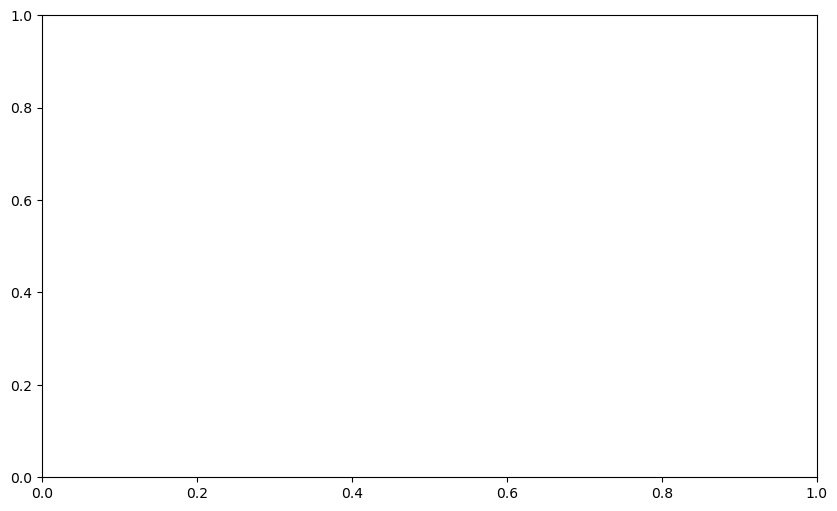

In [18]:
# Set the model to evaluation mode
model.eval()

# Predict parameters beta and gamma
params_pred = model(t_tensor).detach().numpy()

beta_pred = params_pred[:, 0]
gamma_pred = params_pred[:, 1]

print(f"Predicted beta: {beta_pred[-1]:.3f}")
print(f"Predicted gamma: {gamma_pred[-1]:.3f}")

# Simulate the SIR model with the predicted parameters
y_pred = odeint(true_sir, [S0, I0, R0], t, args=(beta_pred[-1], gamma_pred[-1]))
S_pred, I_pred, R_pred = y_pred.T

# Plot the observed and predicted epidemic data
plt.figure(figsize=(10, 6))
plt.plot(t, I_true, 'r', lab='Infected (True)')
plt.plot(t, I_pred, 'b--', label='Infected (Predicted)')
plt.title('Predicted SIR Model using Neural Network (PyTorch)')
plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.legend()
plt.grid(True)
plt.show()
